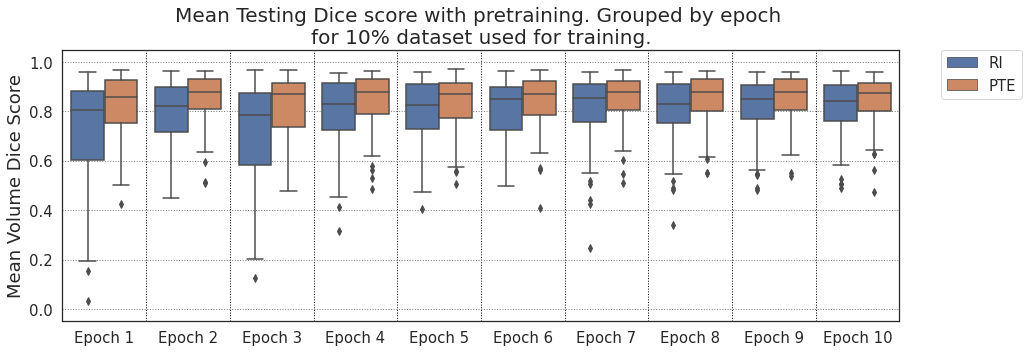

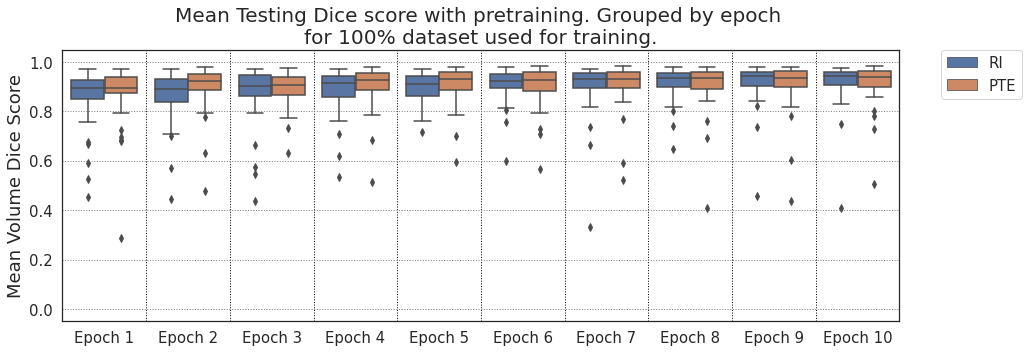

In [5]:
# Show the results of training on fewer annotated examples, applied to the test dataset

from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv  

sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})
for value in ["10","100"]:
    epoch = 0
    show_ones = False
    for train_stage in ["Testing"]:
        percentage_array = [0,1,2,3,4,5,6,7,8,9]
        inputs,inputs2 = ["","","","","","","","","",""],["","","","","","","","","",""]
        pred_type = ["predictions_sigmoid","predictions"]

        for percentage in range(len(percentage_array)):
            inputs[percentage] = "Test_outputs/Brats_RI_D"+value+"_C100_E10_0/Epoch_" + str(percentage_array[percentage]) + "/" + "_Dice_predictions.csv"
            inputs2[percentage] = "Test_outputs/Brats_PTE_D"+value+"_C100_E10_0/Epoch_" + str(percentage_array[percentage]) + "/" +  "_Dice_predictions.csv"

        title_output_model = ["RI", "PTE"]
        col_name = ["Epoch 1","Epoch 2","Epoch 3","Epoch 4","Epoch 5","Epoch 6","Epoch 7","Epoch 8","Epoch 9","Epoch 10"]
        train_data_input = pd.DataFrame(data=None, columns=title_output_model)

        x_array = np.array([])
        y_array = np.array([])
        z_array = np.array([])
        a_array = np.array([])

        index = [0,1,2,3,4,5,6,7,8,9]#,5]
        input_test = [inputs, inputs2]#, inputs3]

        for i in range(len(index)):
            x_array = np.array([])
            y_array = np.array([])
            z_array = np.array([])

            x_array = np.genfromtxt(input_test[0][index[i]], delimiter=',',invalid_raise = False)
            x_array = np.ndarray.flatten(x_array)
            if show_ones == True:
                x_array[x_array == 1] = np.nan

            y_array = np.genfromtxt(input_test[1][index[i]], delimiter=',',invalid_raise = False)
            y_array = np.ndarray.flatten(y_array)
            if show_ones == True:
                y_array[y_array == 1] = np.nan

            df1 = pd.DataFrame(data = {"Division":np.full(len(x_array), col_name[index[i]]),
                                       "RI":x_array,"PTE":y_array})#,"PTE":z_array})
            train_data_input = train_data_input.append(df1,ignore_index=True)

        data = train_data_input.melt('Division', var_name='Model Pre-training level', value_name='Mean Dice')
        fig = plt.figure(figsize=(15,5))
        plt.grid()
        ax=sns.boxplot(y='Mean Dice', x='Division', hue='Model Pre-training level', data=data)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.title("Mean "+train_stage+" Dice score with pretraining. Grouped by epoch \nfor "+value+"% dataset used for training."
                 ,fontsize=20)
        plt.ylim(-0.05,1.05)
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=1)
        plt.xlabel("",fontsize=18)
        plt.ylabel("Mean Volume Dice Score",fontsize=18)
        plt.show()

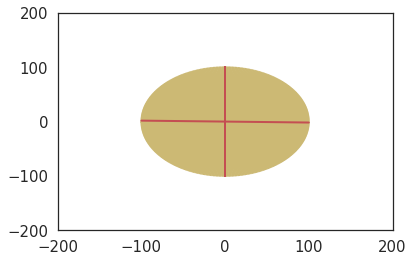

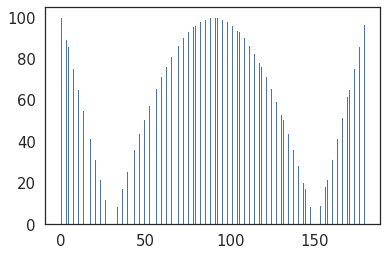

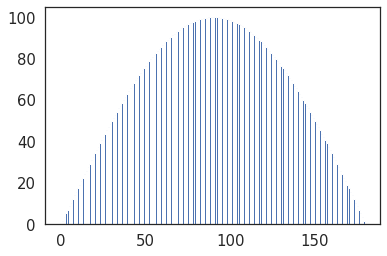

In [6]:
# Ablation studues on differing cosine penalties for orthogonality weighting
import Code_UNet_2.Code_UNet_Re.Net_modules.Penalty_2 as penalty
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import math
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= str(3)
loss,mse,cosine = 0,0,0

Penalty = penalty.Penalty(100)

def rotate(point, origin, degrees):
    
    radians = degrees
    x,y = point
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return qx, qy

testing_rano_1_pred = [-0.,  -100.,  0., 100., -100.,  0.,  100., -0.]

max_angle = 180
angle_out = np.zeros(max_angle)
angle_out2 = np.zeros(max_angle)
for angle in range(max_angle):
    testing_rano_1_pred = [-0.,  -100.,  0., 100., -100.,  0.,  100., -0.]

    testing_rano_1_out = testing_rano_1_pred
    
    x = rotate([testing_rano_1_out[0],testing_rano_1_out[1]], origin = (0,0), degrees = np.deg2rad(angle))
    y = rotate([testing_rano_1_out[2],testing_rano_1_out[3]], origin = (0,0), degrees = np.deg2rad(angle))
    
    testing_rano_1_true = [0,0,0,0,0,0,0,0]
    
    testing_rano_1_out[0] = x[0]
    testing_rano_1_out[1] = x[1]
    testing_rano_1_out[2] = y[0]
    testing_rano_1_out[3] = y[1]

    D1 = np.asarray([[testing_rano_1_out[1],testing_rano_1_out[3]],[testing_rano_1_out[0],testing_rano_1_out[2]]]) 
    D2 = np.asarray([[testing_rano_1_out[5],testing_rano_1_out[7]],[testing_rano_1_out[4],testing_rano_1_out[6]]]) 
    
    plt.plot(D1[0, :], D1[1, :], lw=2, c='y',label='_nolegend_')
    plt.plot(D2[0, :], D2[1, :], lw=2, c='r',label='Prediction')

    output = torch.from_numpy(np.array([testing_rano_1_out]).astype(float)).to("cuda")

    target = torch.from_numpy(np.array([testing_rano_1_out]).astype(float)).to("cuda")

    mean, mse, cosine = Penalty.MSELossorthog(output, target)
    angle_out[angle] = cosine.item()
    
    mean, mse, cosine = Penalty.MSELossorthogtest2_4(output, target)
    angle_out2[angle] = cosine.item()
    
plt.xlim([-200, 200])
plt.ylim([-200, 200])

D1 = np.asarray([[testing_rano_1_pred[1],testing_rano_1_pred[3]],[testing_rano_1_pred[0],testing_rano_1_pred[2]]]) 
D2 = np.asarray([[testing_rano_1_pred[5],testing_rano_1_pred[7]],[testing_rano_1_pred[4],testing_rano_1_pred[6]]]) 
    
plt.plot(D1[0, :], D1[1, :], lw=2, c='r',label='_nolegend_')
plt.plot(D2[0, :], D2[1, :], lw=2, c='r',label='Prediction')

plt.show()

plt.bar(range(max_angle),angle_out)
plt.show()

plt.bar(range(max_angle),angle_out2)
plt.show()

Regression


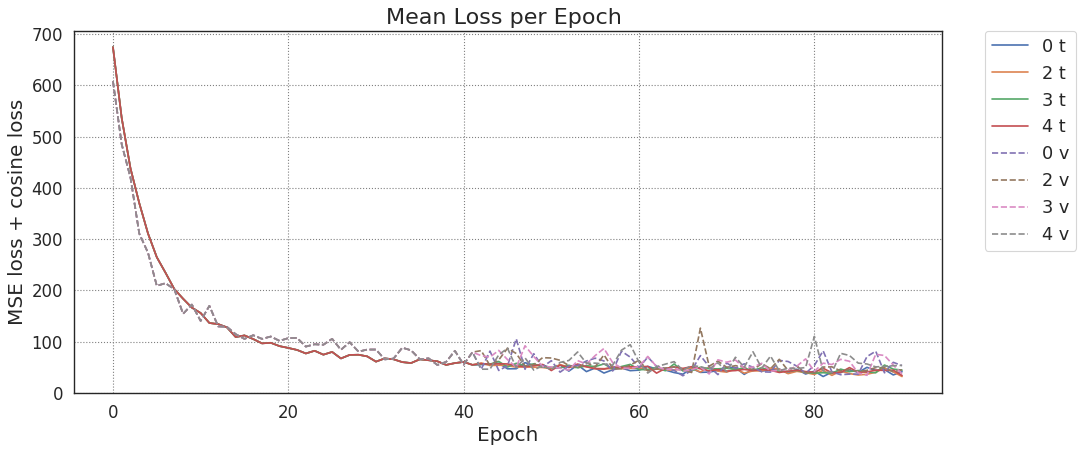

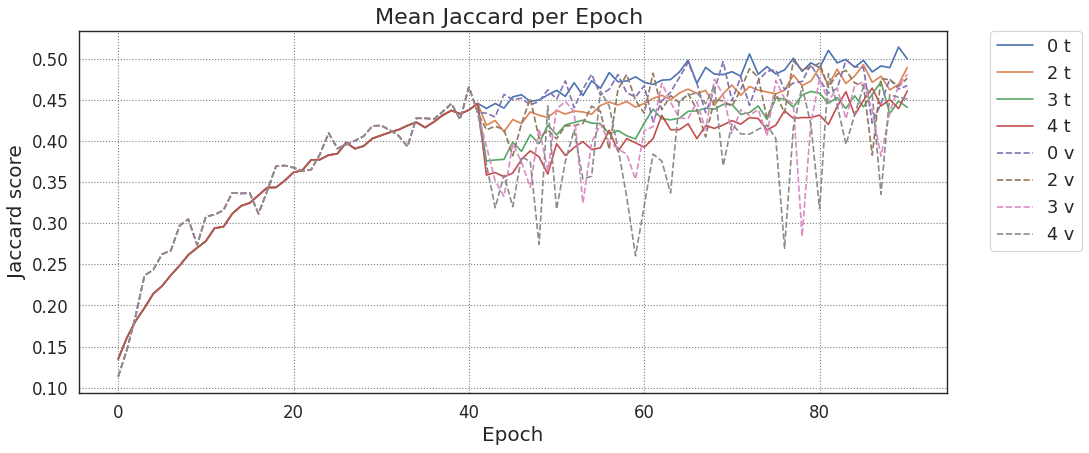

In [2]:
# sort out loss plots for training and validation here with 
# the new file format (will make it easier to transfer the 
# plots to the CT examples when we do this!)

# RANO output loss for both training and validation - over differing penalty types
print("Regression")
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Prior_Epochs = 42
Epochs = 49

sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names1 = ["cosine_absolute_values_c0_e100",
               "cosine_absolute_values_c0_e100",
               "cosine_absolute_values_c0_e100",
               "cosine_absolute_values_c0_e100"]

input_names2 = ["cosine_absolute_values_c_0_e100_Continue",
               "cosine_absolute_values_c_2_e100_Continue",
               "cosine_absolute_values_c_3_e100_Continue",
               "cosine_absolute_values_c_4_e100_Continue"]

legend_names = ["0 t",
                "2 t",
                "3 t",
                "4 t",
                "0 v",
                "2 v",
                "3 v",
                "4 v"]

output_type = ["training_loss","training_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["Training_loss","Validation_loss"]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
#     print(output_type[c])
#     print(c)
    for s in range(len(input_names1)):
#         print(input_names1[s])
#         print(s)
        
        for i in range(Prior_Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names1[s]+ "/" + second_out[c] + "/epoch_"+str(i + 1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]
                
        for i in range(Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names2[s]+ "/" + second_out[c] + "/epoch_"+str(i + 1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
#             print(loss_Nan_0)
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
#             print(loss_Nan_0)
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()    

output_type = ["training_loss","training_loss"]
output_axis = ["Jaccard score"]
output_title = ["Jaccard"]
second_out = ["Training_Jaccard","Validation_Jaccard"]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names1)):
        for i in range(Prior_Epochs):
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names1[s]+ "/" + second_out[c] + "/epoch_"+str(i + 1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]
        for i in range(Epochs):
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names2[s]+ "/" + second_out[c] + "/epoch_"+str(i + 1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
#             print(loss_Nan_0)
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
#             print(loss_Nan_0)
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()  

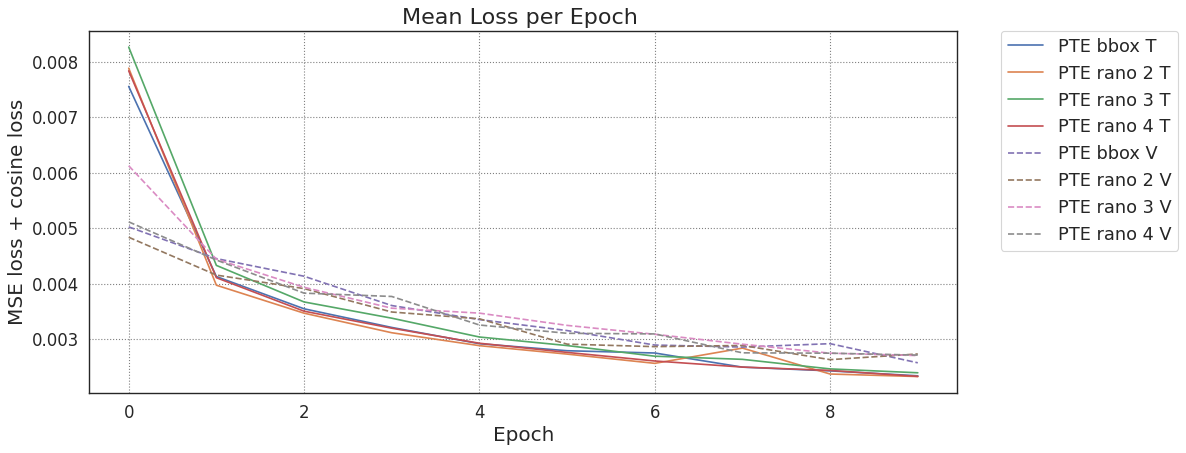

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: C

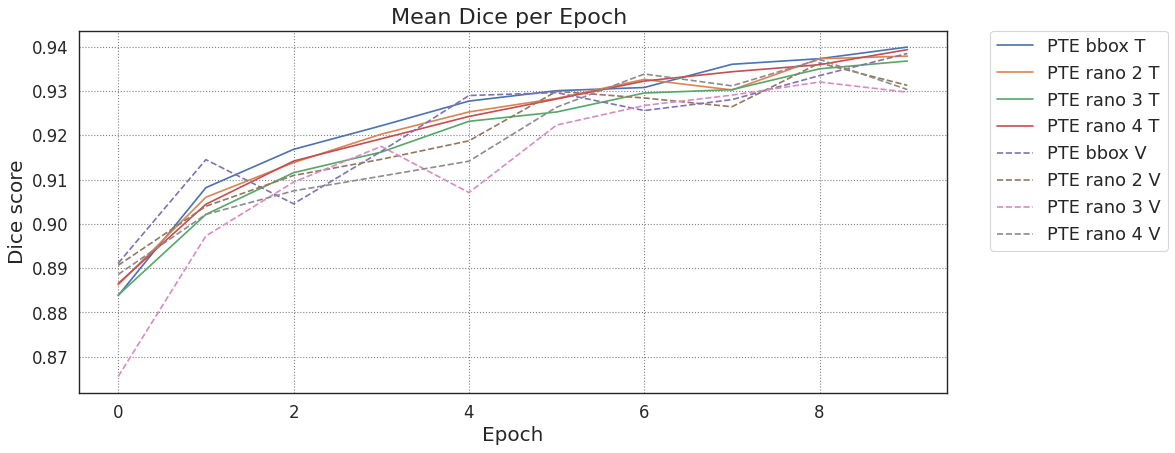

In [10]:
# print("Regression")
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 2 is good
# 3 is worse
# 4 is best
# 100 is worse

Epochs = 10
sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names = ["BBOX_training_sample_1_PTE",
               "RANO_cosine_cont_2_PTE",
               "RANO_cosine_cont_3_PTE",
               "RANO_cosine_cont_4_PTE"]

legend_names = ["PTE bbox T","PTE rano 2 T","PTE rano 3 T","PTE rano 4 T", 
                "PTE bbox V","PTE rano 2 V","PTE rano 3 V","PTE rano 4 V"]

output_type = ["training_loss","validation_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):

            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv",delimiter=',', invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()    

output_type = ["training_dice","validation_dice"]
output_axis = ["Dice score"]
output_title = ["Dice"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv",delimiter=',', invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()  

Regression
training_loss
0
BBOX_training_sample_1
0
cosine_absolute_values_c_5_e100_Continue
1
training_loss
1
BBOX_training_sample_1
0
cosine_absolute_values_c_5_e100_Continue
1


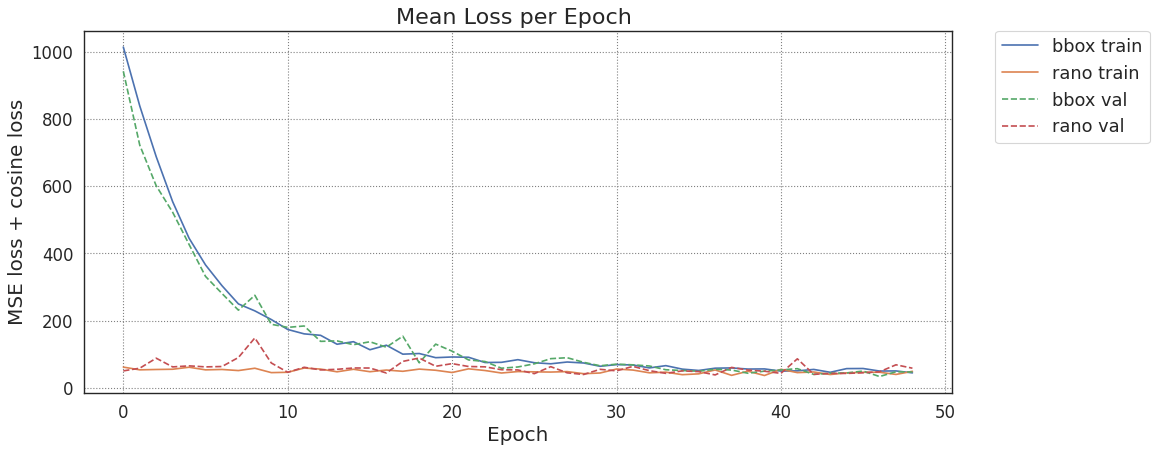

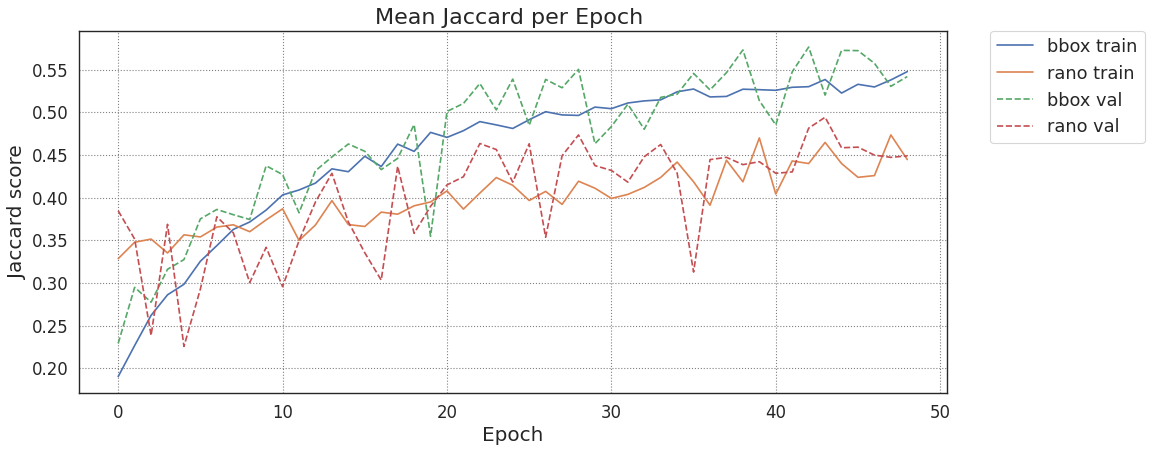

In [7]:
# results from regressing on a bounding box compared to p_Rano
# sort out loss plots for training and validation here with 
# the new file format (will make it easier to transfer the 
# plots to the CT examples when we do this!)

# RANO output loss for both training and validation - over differing penalty types
print("Regression")
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Epochs = 49

sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names = ["BBOX_training_sample_1","cosine_absolute_values_c_5_e100_Continue"]
# input_names = ["Prano_pretrain_1_C100"]
# input_names = ["brats_regress_100_c_10000_Prano_100_epochs"]
#
legend_names = ["bbox train","rano train" , "bbox val", "rano val"]

output_type = ["training_loss","training_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["Training_loss","Validation_loss"]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    print(output_type[c])
    print(c)
    for s in range(len(input_names)):
        print(input_names[s])
        print(s)
        for i in range(Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i+1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()    

output_type = ["training_loss","training_loss"]
output_axis = ["Jaccard score"]
output_title = ["Jaccard"]
second_out = ["Training_Jaccard","Validation_Jaccard"]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i+1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()  

# for some reasont eh values of jaccard for 0 and 10000 are the same, not sure why this is the case but will redo some training to find out,
# also not saving the hyperparameters for rano so need to fix that

In [1]:
print("Regression")
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tabulate import tabulate

Epochs = 49

sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names = ["BBOX_training_sample_1","cosine_absolute_values_c_5_e100_Continue"]

axis_1 = ["Epoch"]
for xx in range(Epochs):
    axis_1.append(str(xx + 1))

valdata = [axis_1,["Bounding box"],["PTE cosine x1"]]
traindata = [axis_1,["Bounding box"],["PTE cosine x1"]]

legend_names = ["bbox train","rano train" , "bbox val", "rano val"]

output_type = ["training_loss","training_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["Training_loss","Validation_loss"]

loss_0 = []
loss_Nan_0 = []

print("Loss")

for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i+1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            valdata[s+1].extend(np.around(loss_Nan_0,6))
        if c == 0:
            traindata[s+1].extend(np.around(loss_Nan_0,6))
        loss_0 = []
        loss_Nan_0 = []

print(tabulate(np.array(valdata).T.tolist(),headers=["Validation"], tablefmt="fancy_grid"))

print(tabulate(np.array(traindata).T.tolist(),headers=["Training"], tablefmt="fancy_grid"))

valdata = [axis_1,["Bounding box"],["PTE cosine x1"]]
traindata = [axis_1,["Bounding box"],["PTE cosine x1"]]

output_type = ["training_loss","training_loss"]
output_axis = ["Jaccard score"]
output_title = ["Jaccard"]
second_out = ["Training_Jaccard","Validation_Jaccard"]

loss_0 = []
loss_Nan_0 = []

print("Jaccard")

for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            
            loss_0 = np.genfromtxt("Checkpoints_RANO/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i+1)+output_type[c] + ".csv",delimiter=',')
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            valdata[s+1].extend(np.around(loss_Nan_0,6))
        if c == 0:
            traindata[s+1].extend(np.around(loss_Nan_0,6))
        loss_0 = []
        loss_Nan_0 = []

print(tabulate(np.array(valdata).T.tolist(),headers=["Validation"], tablefmt="fancy_grid"))

print(tabulate(np.array(traindata).T.tolist(),headers=["Training"], tablefmt="fancy_grid"))

Regression
Loss
╒═══════╤══════════════╤═══════════════╕
│       │              │ Validation    │
╞═══════╪══════════════╪═══════════════╡
│ Epoch │ Bounding box │ PTE cosine x1 │
├───────┼──────────────┼───────────────┤
│ 1     │ 942.773036   │ 49.974236     │
├───────┼──────────────┼───────────────┤
│ 2     │ 722.665268   │ 57.969072     │
├───────┼──────────────┼───────────────┤
│ 3     │ 601.702613   │ 87.794825     │
├───────┼──────────────┼───────────────┤
│ 4     │ 522.806029   │ 61.81547      │
├───────┼──────────────┼───────────────┤
│ 5     │ 426.72552    │ 64.950481     │
├───────┼──────────────┼───────────────┤
│ 6     │ 331.561278   │ 61.904226     │
├───────┼──────────────┼───────────────┤
│ 7     │ 280.751191   │ 62.977955     │
├───────┼──────────────┼───────────────┤
│ 8     │ 230.943038   │ 89.802548     │
├───────┼──────────────┼───────────────┤
│ 9     │ 275.296273   │ 148.15394     │
├───────┼──────────────┼───────────────┤
│ 10    │ 188.856975   │ 73.554652     │


╒═══════╤══════════════╤═══════════════╕
│       │              │ Validation    │
╞═══════╪══════════════╪═══════════════╡
│ Epoch │ Bounding box │ PTE cosine x1 │
├───────┼──────────────┼───────────────┤
│ 1     │ 0.229135     │ 0.384604      │
├───────┼──────────────┼───────────────┤
│ 2     │ 0.294835     │ 0.351436      │
├───────┼──────────────┼───────────────┤
│ 3     │ 0.277413     │ 0.238442      │
├───────┼──────────────┼───────────────┤
│ 4     │ 0.315979     │ 0.368708      │
├───────┼──────────────┼───────────────┤
│ 5     │ 0.327367     │ 0.22555       │
├───────┼──────────────┼───────────────┤
│ 6     │ 0.375116     │ 0.292899      │
├───────┼──────────────┼───────────────┤
│ 7     │ 0.386143     │ 0.377518      │
├───────┼──────────────┼───────────────┤
│ 8     │ 0.38001      │ 0.358858      │
├───────┼──────────────┼───────────────┤
│ 9     │ 0.37442      │ 0.30037       │
├───────┼──────────────┼───────────────┤
│ 10    │ 0.437393     │ 0.341716      │
├───────┼───────

Regression


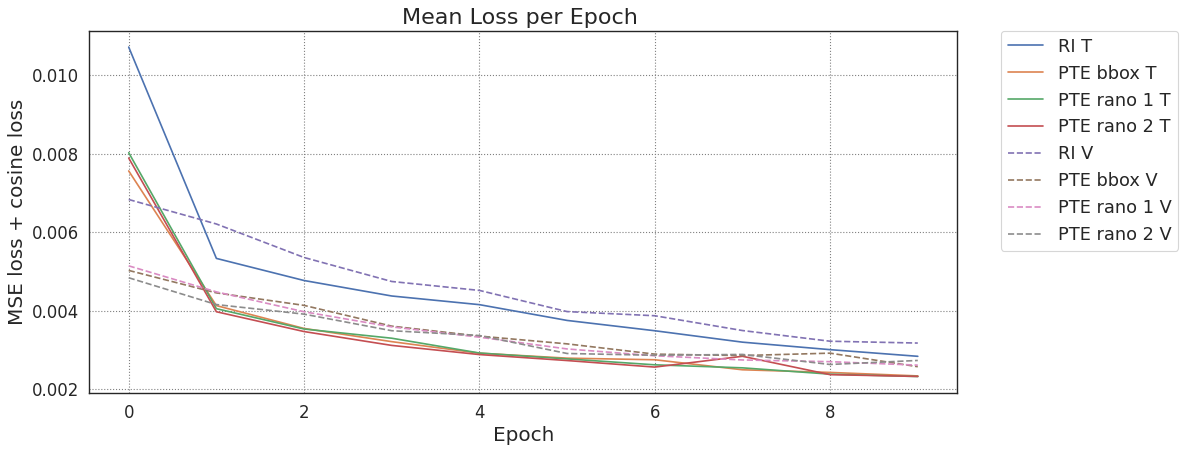

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)


Train [0.83212289 0.87493115 0.88257004 0.88979374 0.89406357 0.90135781
 0.90667313 0.91285096 0.91840778 0.92280144]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)


Train [0.88382942 0.90817129 0.91680954 0.92213349 0.9276999  0.9300454
 0.93076854 0.93600481 0.93726804 0.93988897]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)


Train [0.88486344 0.90479371 0.91340069 0.91745051 0.92444298 0.92747804
 0.93113038 0.93319826 0.93712706 0.93850297]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)


Train [0.88625315 0.90600845 0.91381856 0.92023959 0.92525421 0.92830328
 0.9325939  0.93020933 0.9372576  0.93784933]
val [0.85557805 0.84880989 0.86649217 0.88234966 0.88886846 0.89612197
 0.90109219 0.91497378 0.91790641 0.91408282]
val [0.89111772 0.91449167 0.90452531 0.91634993 0.9289556  0.9296081
 0.92557118 0.92802901 0.93345329 0.93844156]
val [0.87886227 0.89914968 0.90785385 0.90798295 0.91703223 0.92620832
 0.92433964 0.93236076 0.93342943 0.93391558]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)


val [0.89064951 0.90396686 0.9109163  0.91456151 0.91873544 0.92990452
 0.92840306 0.92642111 0.93629913 0.93125367]


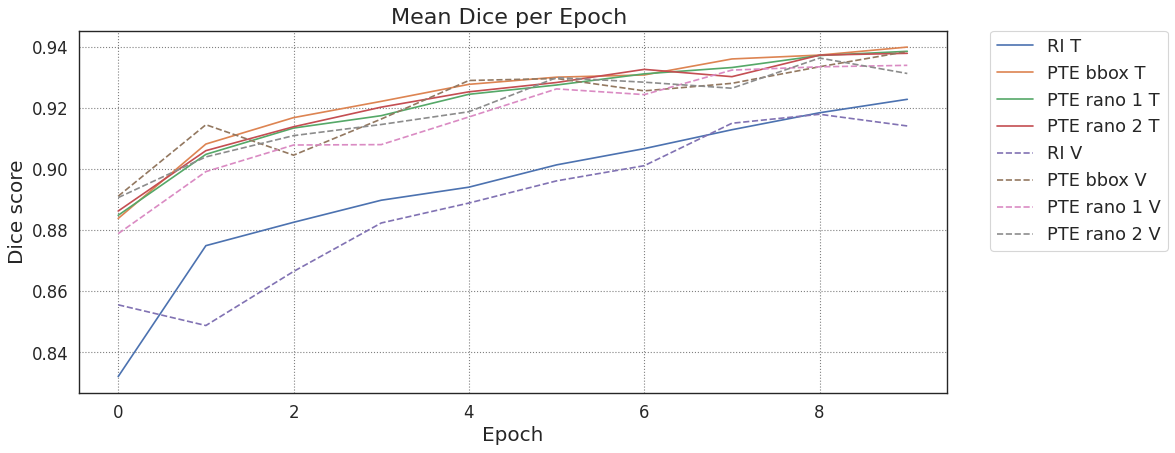

In [11]:
print("Segmentation")
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Epochs = 10
sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names = ["BBOX_training_sample_1_RI",
               "BBOX_training_sample_1_PTE",
               "RANO_cosine_cont_1_PTE",
               "RANO_cosine_cont_2_PTE"]

legend_names = ["RI T","PTE bbox T","PTE rano 1 T","PTE rano 2 T", 
               "RI V","PTE bbox V","PTE rano 1 V","PTE rano 2 V"]

output_type = ["training_loss","validation_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):

            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv",delimiter=',', invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show()    

output_type = ["training_dice","validation_dice"]
output_axis = ["Dice score"]
output_title = ["Dice"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []
figure(figsize=(14, 6), dpi=80)
ax = plt.subplot()
for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s]+ "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv",delimiter=',', invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0,linestyle='dashed')
            print("val", loss_Nan_0)
        if c == 0:
            ax.plot(range(len(loss_Nan_0)),loss_Nan_0)
            print("Train", loss_Nan_0)
        loss_0 = []
        loss_Nan_0 = []

plt.title("Mean " + output_title[0] + " per Epoch ",fontsize=20)
ax.legend(legend_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.xlabel("Epoch",fontsize=18)
plt.ylabel(ylabel=output_axis[0],fontsize=18)
plt.grid()
plt.show() 

In [38]:
print("Segmentations results")

from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tabulate import tabulate


Epochs = 10
sns.set(font_scale = 1.35)
sns.set_style("white",{"grid.color": ".5", "grid.linestyle": ":"})

input_names = ["BBOX_training_sample_1_RI",
               "BBOX_training_sample_1_PTE",
               "RANO_cosine_cont_1_PTE",
               "RANO_cosine_cont_2_PTE"]

axis_1 = ["Epoch"]
for xx in range(Epochs):
    axis_1.append(str(xx + 1))

# axis_1 = np.array(axis_1).T.tolist()

valdata = [axis_1,["Random init"],["Bounding box"],["PTE cosine x1"],["PTE cosine x2"]]
traindata = [axis_1,["Random init"],["Bounding box"],["PTE cosine x1"],["PTE cosine x2"]]

legend_names = ["RI T","PTE bbox T","PTE rano 1 T","PTE rano 2 T", 
               "RI V","PTE bbox V","PTE rano 1 V","PTE rano 2 V"]

output_type = ["training_loss","validation_loss"]
output_axis = ["MSE loss + cosine loss"]
output_title = ["Loss"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []
# figure(figsize=(14, 6), dpi=80)
# ax = plt.subplot()

print("Loss")

for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):

            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s] + "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv"
                                   ,delimiter=','
                                   , invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            valdata[s+1].extend(np.around(loss_Nan_0,6))
        if c == 0:
            traindata[s+1].extend(np.around(loss_Nan_0,6))
        loss_0 = []
        loss_Nan_0 = []

print(tabulate(np.array(valdata).T.tolist(),headers=["Validation"], tablefmt="fancy_grid"))

print(tabulate(np.array(traindata).T.tolist(),headers=["Training"], tablefmt="fancy_grid"))

valdata = [axis_1,["Random init"],["Bounding box"],["PTE cosine x1"],["PTE cosine x2"]]
traindata = [axis_1,["Random init"],["Bounding box"],["PTE cosine x1"],["PTE cosine x2"]]

output_type = ["training_dice","validation_dice"]
output_axis = ["Dice score"]
output_title = ["Dice"]
second_out = ["",""]

loss_0 = []
loss_Nan_0 = []

print("Dice")

for c in range(len(output_type)):
    for s in range(len(input_names)):
        for i in range(Epochs):
            loss_0 = np.genfromtxt("Checkpoints/Checkpoints/"+ input_names[s] + "/" + second_out[c] + "/epoch_"+str(i)+output_type[c] + ".csv"
                                   ,delimiter=','
                                   , invalid_raise = False)
            loss_Nan_0 = np.append(loss_Nan_0, np.mean(loss_0[np.logical_not(np.isnan(loss_0))]))
            if c > (len(output_type) - 3):
                loss_Nan_0[i] = loss_Nan_0[i]

        if c == 1:
            valdata[s+1].extend(np.around(loss_Nan_0,6))
        if c == 0:
            traindata[s+1].extend(np.around(loss_Nan_0,6))
        loss_0 = []
        loss_Nan_0 = []
print(tabulate(np.array(valdata).T.tolist(),headers=["Validation"], tablefmt="fancy_grid"))

print(tabulate(np.array(traindata).T.tolist(),headers=["Training"], tablefmt="fancy_grid"))

Segmentations results
Loss
╒═══════╤═════════════╤══════════════╤═══════════════╤═══════════════╕
│       │             │              │               │ Validation    │
╞═══════╪═════════════╪══════════════╪═══════════════╪═══════════════╡
│ Epoch │ Random init │ Bounding box │ PTE cosine x1 │ PTE cosine x2 │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 1     │ 0.00683     │ 0.005023     │ 0.00514       │ 0.004836      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 2     │ 0.006207    │ 0.004451     │ 0.004477      │ 0.004154      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 3     │ 0.005353    │ 0.004133     │ 0.00397       │ 0.003909      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 4     │ 0.004741    │ 0.003604     │ 0.003585      │ 0.003487      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 5     │ 0.004514    │ 0.00335      │ 0.003322   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: ConversionWarning: Some errors were detected !
    Line #3865 (got 7 columns instead of 8)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: ConversionWarning: Some errors were detected !
    Line #553 (got 1 columns instead of 8)


╒═══════╤═════════════╤══════════════╤═══════════════╤═══════════════╕
│       │             │              │               │ Validation    │
╞═══════╪═════════════╪══════════════╪═══════════════╪═══════════════╡
│ Epoch │ Random init │ Bounding box │ PTE cosine x1 │ PTE cosine x2 │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 1     │ 0.855578    │ 0.891118     │ 0.878862      │ 0.89065       │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 2     │ 0.84881     │ 0.914492     │ 0.89915       │ 0.903967      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 3     │ 0.866492    │ 0.904525     │ 0.907854      │ 0.910916      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 4     │ 0.88235     │ 0.91635      │ 0.907983      │ 0.914562      │
├───────┼─────────────┼──────────────┼───────────────┼───────────────┤
│ 5     │ 0.888868    │ 0.928956     │ 0.917032      │ 0.918735      │
├─────

+-------+--------------------+--------------------+
| Epoch |      RI dice       |      PTE dice      |
+-------+--------------------+--------------------+
|   0   | 0.7158245305374772 | 0.8267387748734399 |
|   1   | 0.7829349979438381 | 0.8467602855907422 |
|   2   | 0.7051936410867676 | 0.8213036496589172 |
|   3   | 0.7796163982123689 | 0.8384125603343704 |
|   4   | 0.7944874650199294 | 0.8325614035866554 |
|   5   | 0.8117931333579189 | 0.8368170800686368 |
|   6   | 0.8011026387292446 | 0.8457583886370084 |
|   7   | 0.8041190398719672 | 0.8445293405384181 |
|   8   | 0.8133741384405638 | 0.8510366865445217 |
|   9   | 0.8156644591467559 | 0.8426119936102403 |
+-------+--------------------+--------------------+


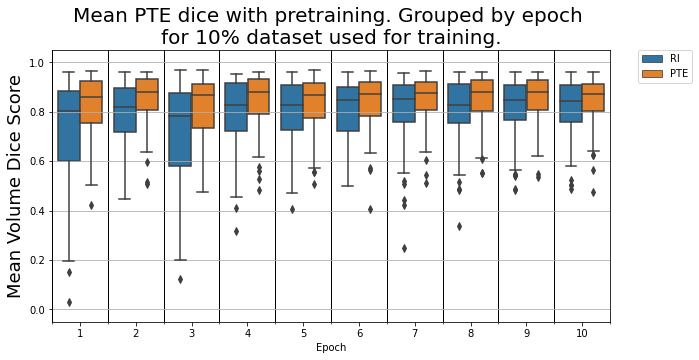

+-------+--------------------+--------------------+
| Epoch |      RI hd95       |      PTE hd95      |
+-------+--------------------+--------------------+
|   0   | 17.662766246419196 | 11.15360322416874  |
|   1   | 27.501498468298653 | 11.789187525657189 |
|   2   | 13.059373241558404 |  9.35582279573407  |
|   3   | 19.553470043550455 | 9.312955375303302  |
|   4   | 16.89256458909887  | 11.226861787260615 |
|   5   | 26.177789849147462 | 16.850105071486084 |
|   6   | 13.416162080513802 | 17.03499424792172  |
|   7   | 15.228715807931458 | 11.02981874859123  |
|   8   | 19.56050358947955  | 11.713587186629308 |
|   9   | 18.874899852066704 | 14.357995837613151 |
+-------+--------------------+--------------------+


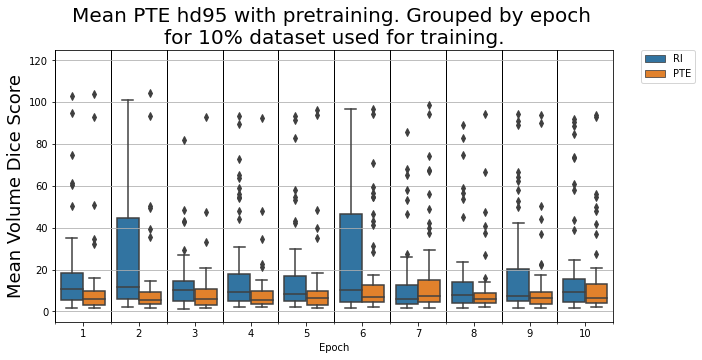

+-------+--------------------+--------------------+
| Epoch |    RI precision    |   PTE precision    |
+-------+--------------------+--------------------+
|   0   | 0.9458341059708274 | 0.933803641219312  |
|   1   | 0.8815215895087485 | 0.9066639533149073 |
|   2   | 0.9696812883458348 | 0.9432727097309909 |
|   3   | 0.9054321002991701 | 0.9135481724890311 |
|   4   | 0.9159324019257381 | 0.9333055304997958 |
|   5   | 0.8796299740530928 | 0.8969804024613556 |
|   6   | 0.9350269532337155 | 0.8937445246578247 |
|   7   | 0.9272292656484244 | 0.9055766716263864 |
|   8   | 0.9073786805727933 | 0.9059864544692592 |
|   9   | 0.9123228342403471 | 0.8962364056505913 |
+-------+--------------------+--------------------+


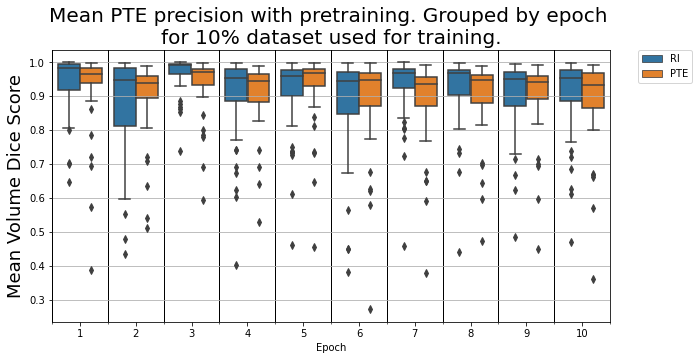

+-------+--------------------+--------------------+
| Epoch |     RI recall      |     PTE recall     |
+-------+--------------------+--------------------+
|   0   | 0.6327549430563036 | 0.7637926577472539 |
|   1   | 0.753077332038935  | 0.8140232948817555 |
|   2   | 0.6036717394944843 | 0.7514438340204286 |
|   3   | 0.7313925294200739 | 0.7982465330338651 |
|   4   | 0.740471557786536  | 0.775486695204299  |
|   5   | 0.7914740410788239 | 0.8110278932976034 |
|   6   | 0.7362094837750331 | 0.8265940922962208 |
|   7   | 0.7435619243595465 | 0.8132218183587212 |
|   8   | 0.7710335432668206 | 0.8227708932463553 |
|   9   |  0.77102889848881  | 0.8176313918097033 |
+-------+--------------------+--------------------+


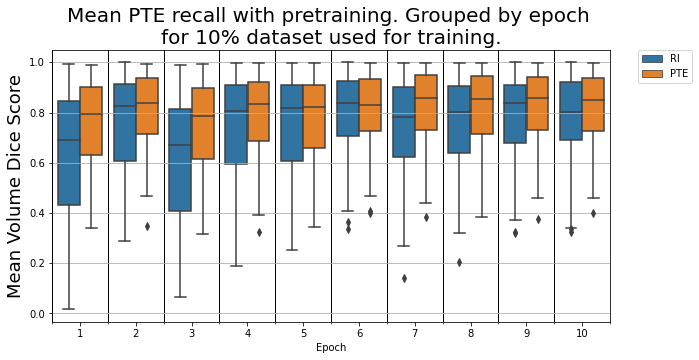

+-------+--------------------+--------------------+
| Epoch |   RI specificity   |  PTE specificity   |
+-------+--------------------+--------------------+
|   0   | 0.9996731246771605 | 0.9995070723087889 |
|   1   | 0.9990452107790216 | 0.9991740115066898 |
|   2   | 0.9998106100805273 |  0.99958275543499  |
|   3   | 0.9991579596055796 | 0.999234760322121  |
|   4   | 0.9992964012781816 | 0.9995127208094129 |
|   5   | 0.9989551992483052 | 0.9991554913002028 |
|   6   | 0.9994695762482523 | 0.9991017171957899 |
|   7   | 0.9994199064012658 | 0.9992109500885088 |
|   8   | 0.9991660448690488 | 0.9991963658113665 |
|   9   | 0.9992538995334752 | 0.9990944801516428 |
+-------+--------------------+--------------------+


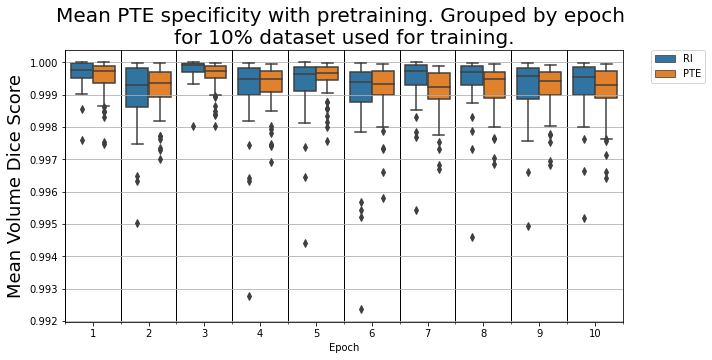


Epoch 4
+-------------+--------------------+--------------------+
|    Metric   |         RI         |        PTE         |
+-------------+--------------------+--------------------+
|     dice    | 0.7944874650199294 | 0.8325614035866554 |
|     hd95    | 16.89256458909887  | 11.226861787260615 |
|  precision  | 0.9159324019257381 | 0.9333055304997958 |
|    recall   | 0.740471557786536  | 0.775486695204299  |
| specificity | 0.9992964012781816 | 0.9995127208094129 |
+-------------+--------------------+--------------------+

####################################################################################################
####################################################################################################
####################################################################################################
+-------+--------------------+--------------------+
| Epoch |      RI dice       |      PTE dice      |
+-------+--------------------+--------------------+
|   0   |

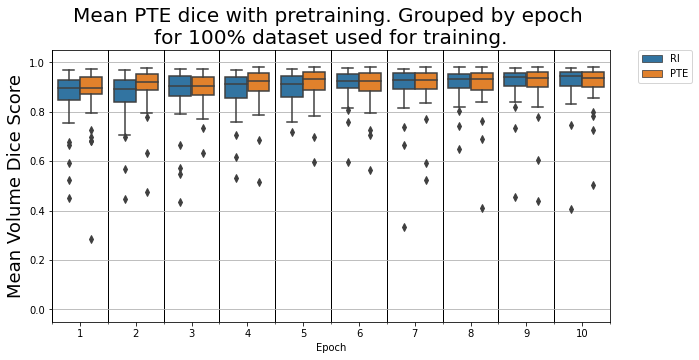

+-------+--------------------+--------------------+
| Epoch |      RI hd95       |      PTE hd95      |
+-------+--------------------+--------------------+
|   0   | 17.791272706734496 | 6.449880609177707  |
|   1   | 15.591745752200733 | 7.1938821022970565 |
|   2   | 5.156119076829206  | 5.695165159409506  |
|   3   | 5.451310657618339  | 6.078021676498543  |
|   4   | 5.003900438024283  | 5.794003708320751  |
|   5   | 6.133878954251606  | 4.344289817308125  |
|   6   | 4.848864503074105  | 6.366815922971357  |
|   7   | 4.078387806290074  | 4.813774417157758  |
|   8   | 4.0312998365937505 | 5.9310224110620045 |
|   9   | 3.4692955880834138 | 5.623851075925325  |
+-------+--------------------+--------------------+


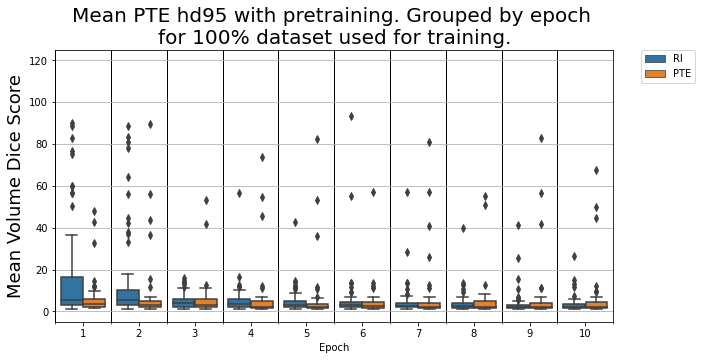

+-------+--------------------+--------------------+
| Epoch |    RI precision    |   PTE precision    |
+-------+--------------------+--------------------+
|   0   | 0.8964944876569749 | 0.939596112304417  |
|   1   | 0.915213710435776  | 0.9342885632933359 |
|   2   | 0.9609995695285416 | 0.9626764435234966 |
|   3   | 0.9660723386315135 | 0.9460328110441353 |
|   4   | 0.9640979527957786 | 0.9423510287769372 |
|   5   | 0.9485410847548937 | 0.9600796957638011 |
|   6   | 0.9448551706552513 | 0.9425567346039131 |
|   7   | 0.953180867008542  | 0.9543748711848871 |
|   8   | 0.9343217775666012 | 0.9414430868184237 |
|   9   | 0.9406144528926589 | 0.9489871486422542 |
+-------+--------------------+--------------------+


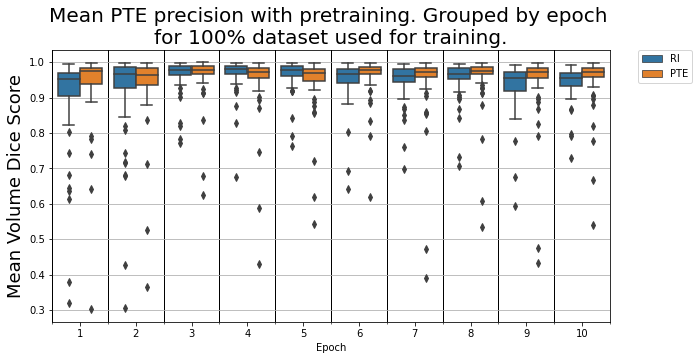

+-------+--------------------+--------------------+
| Epoch |     RI recall      |     PTE recall     |
+-------+--------------------+--------------------+
|   0   | 0.8536538389722536 | 0.8340195163103556 |
|   1   | 0.8470284557640848 | 0.8805311363216114 |
|   2   | 0.8273620990780465 | 0.8323201673399445 |
|   3   | 0.8343943940839628 | 0.8798438646775213 |
|   4   | 0.8431438053902176 |  0.89165831908809  |
|   5   | 0.8828328984827288 | 0.8667214850912719 |
|   6   | 0.878492293866482  | 0.8891553564752944 |
|   7   | 0.8813050268462896 | 0.8751963554465775 |
|   8   | 0.9074992295770083 | 0.8920911792324648 |
|   9   | 0.9074188561852465 | 0.8907377798654682 |
+-------+--------------------+--------------------+


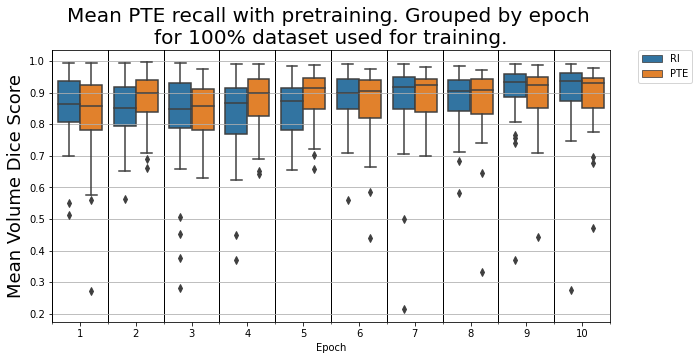

+-------+--------------------+--------------------+
| Epoch |   RI specificity   |  PTE specificity   |
+-------+--------------------+--------------------+
|   0   | 0.9990377335417626 | 0.9995162253506181 |
|   1   | 0.9992626542160513 | 0.9994427002055647 |
|   2   | 0.999668404732008  | 0.999724740568001  |
|   3   | 0.9997023390318736 | 0.9995589922621952 |
|   4   | 0.9997018374515936 | 0.9994973935085595 |
|   5   | 0.9995399462789581 | 0.9996378068974365 |
|   6   | 0.9995014510938133 | 0.9994989138773209 |
|   7   | 0.9995600497239906 | 0.9996257675082317 |
|   8   | 0.9994064789772719 | 0.9994895533095349 |
|   9   | 0.9993913643620704 | 0.999568130624983  |
+-------+--------------------+--------------------+


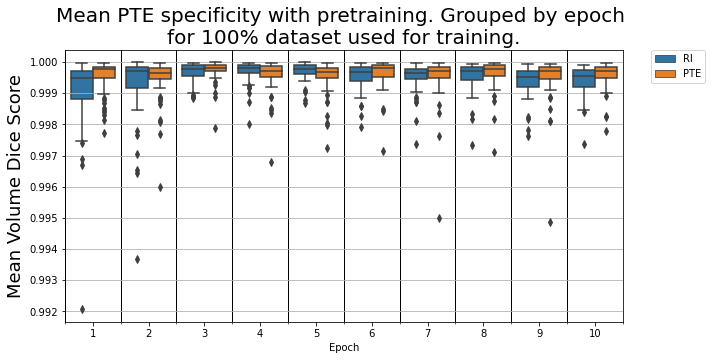


Epoch 4
+-------------+--------------------+--------------------+
|    Metric   |         RI         |        PTE         |
+-------------+--------------------+--------------------+
|     dice    | 0.8966006154905101 | 0.9137360794938589 |
|     hd95    | 5.003900438024283  | 5.794003708320751  |
|  precision  | 0.9640979527957786 | 0.9423510287769372 |
|    recall   | 0.8431438053902176 |  0.89165831908809  |
| specificity | 0.9997018374515936 | 0.9994973935085595 |
+-------------+--------------------+--------------------+

####################################################################################################
####################################################################################################
####################################################################################################


In [12]:
# Additional metrics evaluated, formatted in a table
import numpy as np
import os 
import csv
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv  

from prettytable import PrettyTable

metric_out = []
hd95 = []

from os import listdir
from os.path import isfile, join

epoch_num = 10
output_epoch = 4
folder_list = [[],[]]
in_type = ["RI","PTE"]
index = range(epoch_num)

# recall = sensitivity

col_name = ["1","2",
            "3","4",
            "5","6",
            "7","8",
            "9","10"]
    
for dataset_size in ["10","100"]:
    metrics_table = PrettyTable(['Metric','RI', 'PTE'])
    for metric in ["dice","hd95","precision","recall", "specificity"]:

        x_array = np.array([])
        y_array = np.array([])
        metric_output = []
        
        folder_len = len(listdir(os.getcwd() + "/Test_outputs/Brats_" + in_type[0] + "_D"+dataset_size+"_C100_E10_02/Epoch_"+str(0)+"/Metrics/"))
        
        out_x = np.empty([epoch_num, folder_len])
        out_y = np.empty([epoch_num, folder_len])

        train_data_input = pd.DataFrame(data=None, columns=in_type)

        for val in in_type:
            dice_output = []

            df1 = pd.DataFrame({"RI" : [], "PTE" : []})

            for epoch in range(epoch_num):
                metric_out = []

                x_array = np.array([])
                y_array = np.array([])

                folder_list = [f for f in listdir(os.getcwd() + 
                                      "/Test_outputs/Brats_"+val+"_D"+dataset_size+"_C100_E10_02/Epoch_"+str(epoch)+"/Metrics/") if isfile(join(os.getcwd() + 
                                      "/Test_outputs/Brats_"+val+"_D"+dataset_size+"_C100_E10_02/Epoch_"+str(epoch)+"/Metrics/", f))]

                for folder in range(len(folder_list)):

                    with open(os.getcwd() + "/Test_outputs/Brats_"+val+"_D"+dataset_size+"_C100_E10_02/Epoch_"+str(epoch)+"/Metrics/" + folder_list[folder]) as f:
                        reader = csv.DictReader(f)
                        for row in reader:
                            if metric == "specificity":
                                tp, tn, fp, fn = row['TP'], row['TN'], row['FP'], row['FN']

                                specificity = float(tn) / (float(tn) + float(fp))
                                metric_out.append(specificity)
                            else:

                                metric_out.append(row[metric])

                if val == "RI":
                    x_array = np.append(x_array, metric_out)
                    out_x[epoch] = x_array

                if val == "PTE":
                    y_array = np.append(y_array, metric_out)
#                     print(np.shape(y_array))
                    out_y[epoch] = y_array

                x_array = x_array.astype(np.float)
                y_array = y_array.astype(np.float)

        for var in range(len(out_x)):
            df1 = pd.DataFrame(data = {"Epoch":np.full(len(out_x[var]), col_name[index[var]]),
                                           "RI":out_x[var],"PTE":out_y[var]})#,"PTE":z_array})

            train_data_input = train_data_input.append(df1,ignore_index=True)
            
            t = PrettyTable(['Epoch',"RI " + metric, "PTE " + metric])
            for a in range(epoch_num):
                t.add_row([a, np.mean(out_x[a]), np.mean(out_y[a])])
                
        for f_epoch in [output_epoch]:
            metrics_table.add_row([metric, np.mean(out_x[output_epoch]), np.mean(out_y[output_epoch])])
            print(t)
            metric_out = []
        x_array = np.array([])
        y_array = np.array([])
        

        data = train_data_input.melt('Epoch', var_name='Model Pre-training level', value_name='Mean Dice')
        fig = plt.figure(figsize=(10,5))
        plt.grid()
        ax=sns.boxplot(y='Mean Dice', x='Epoch', hue='Model Pre-training level', data=data)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.title("Mean " + val + " " + metric + " with pretraining. Grouped by epoch \nfor "+dataset_size+"% dataset used for training."
                 ,fontsize=20)
        if metric == "dice":
            plt.ylim(-0.05,1.05)
        if metric == "hd95":
            plt.ylim(-5,125)
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=1)
        plt.ylabel("Mean Volume Dice Score",fontsize=18)
        plt.show()
    print("")
    print("Epoch " + str(output_epoch))
    print(metrics_table)
    print("")
    print("####################################################################################################")
    print("####################################################################################################")
    print("####################################################################################################")


+-------+--------------------+--------------------+--------------------+
| Epoch |      RI dice       |      PTE dice      |     BBox dice      |
+-------+--------------------+--------------------+--------------------+
|   0   | 0.8324336908246921 | 0.8205472805705142 | 0.8400131805682899 |
|   1   | 0.8275370083734374 | 0.844382725415253  | 0.8569940375784645 |
|   2   | 0.827211333631482  | 0.8478236960294544 | 0.8496906166038287 |
|   3   | 0.8528708852265705 |  0.84955497601099  | 0.8524175405235108 |
|   4   | 0.8425696879040313 | 0.839625677659802  | 0.8530698408182301 |
|   5   | 0.8545471420477874 | 0.8495633695394694 | 0.8519978862522749 |
|   6   | 0.8535727826873728 | 0.8559492700969005 | 0.8428690655921489 |
|   7   | 0.8566307261831189 | 0.8445091105201121 | 0.847412269964854  |
|   8   | 0.8458093337373099 | 0.852334578339586  | 0.8400128289592563 |
+-------+--------------------+--------------------+--------------------+


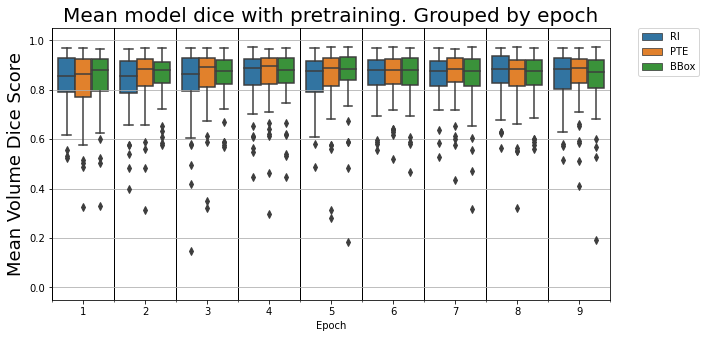

+-------+--------------------+--------------------+--------------------+
| Epoch |      RI hd95       |      PTE hd95      |     BBox hd95      |
+-------+--------------------+--------------------+--------------------+
|   0   | 18.963902132134688 | 9.274711253768515  | 8.390343691173353  |
|   1   | 20.397767999715963 | 11.053932660504392 | 18.10228260567314  |
|   2   | 11.138968762180262 | 11.504391558965047 | 21.127541131722293 |
|   3   | 12.91845132928146  | 11.342286559573392 | 13.50753342017791  |
|   4   | 11.168343079717532 | 11.031418596234234 | 10.709930646628663 |
|   5   | 11.144348118597998 | 15.942812233222151 | 12.029425629398277 |
|   6   | 7.870675584726161  | 17.32442367662463  | 10.576995983876678 |
|   7   | 11.287091980064123 | 11.298198950918097 | 14.641310994039472 |
|   8   | 8.416593994592366  | 12.580694693849797 | 13.325010067538203 |
+-------+--------------------+--------------------+--------------------+


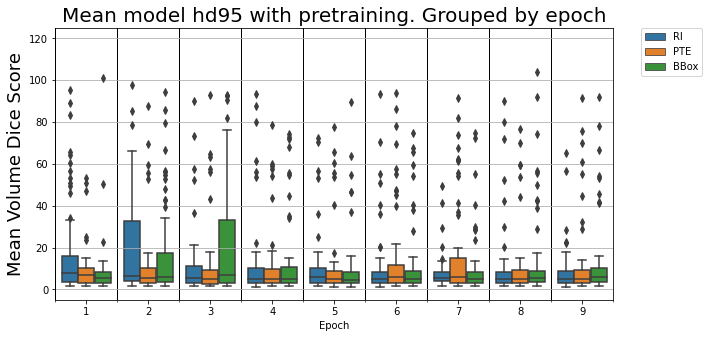

+-------+--------------------+--------------------+--------------------+
| Epoch |    RI precision    |   PTE precision    |   BBox precision   |
+-------+--------------------+--------------------+--------------------+
|   0   | 0.9123589332073444 | 0.9453451265957828 | 0.9549907146177805 |
|   1   | 0.8958861915996247 | 0.9386619880475601 | 0.9076467392635466 |
|   2   | 0.9374972172695549 | 0.9256653313376422 | 0.9136352411386852 |
|   3   | 0.926782258409436  | 0.9271408292670079 | 0.9265736543501384 |
|   4   | 0.9452310808773533 | 0.9380919411311799 | 0.9270919083231286 |
|   5   | 0.9447008796684708 | 0.9176853661661999 | 0.9323396039288482 |
|   6   | 0.9514114087687082 | 0.903497572657456  | 0.9486835767527375 |
|   7   | 0.9296562200850209 | 0.9366827834950728 | 0.9372303318370999 |
|   8   | 0.9441104425565923 | 0.9211344940552082 | 0.9262866687297115 |
+-------+--------------------+--------------------+--------------------+


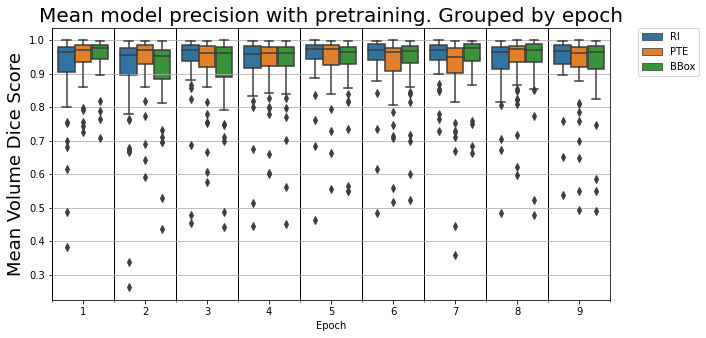

+-------+--------------------+--------------------+--------------------+
| Epoch |     RI recall      |     PTE recall     |    BBox recall     |
+-------+--------------------+--------------------+--------------------+
|   0   | 0.7959358187851605 | 0.7531037686400012 | 0.7710935798116949 |
|   1   | 0.797897262790862  | 0.7887400804174152 | 0.8267875748037803 |
|   2   | 0.7732848604647443 | 0.8026774078721319 | 0.8118239126426791 |
|   3   | 0.812093054481586  | 0.8040953024462104 | 0.8088743242195746 |
|   4   | 0.7796329232527546 | 0.7820488399538619 | 0.8076157519149585 |
|   5   | 0.7956410537170384 | 0.807494656820474  | 0.8022968586582877 |
|   6   | 0.786420204975795  | 0.8311058584298804 | 0.7760233635390762 |
|   7   | 0.8126440073467102 | 0.7886892317411087 | 0.7902183888345045 |
|   8   | 0.7861805783526791 | 0.8133108620764322 | 0.7886131228495799 |
+-------+--------------------+--------------------+--------------------+


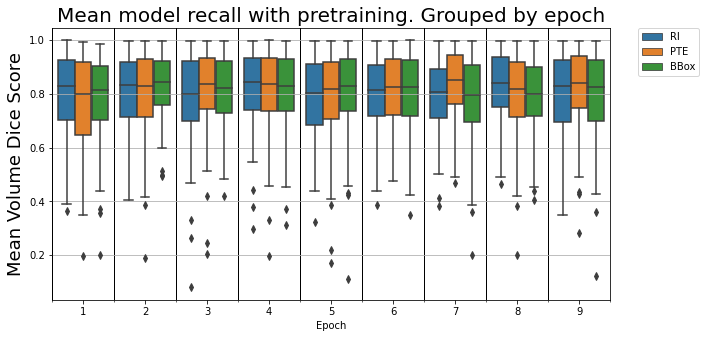

+-------+--------------------+--------------------+--------------------+
| Epoch |   RI specificity   |  PTE specificity   |  BBox specificity  |
+-------+--------------------+--------------------+--------------------+
|   0   | 0.9992647065757277 | 0.9995816706742232 | 0.9996241208426366 |
|   1   | 0.9990545643564538 | 0.9995271095268501 | 0.9992069255864281 |
|   2   | 0.9994799964413408 | 0.999427656927599  | 0.9993139898136956 |
|   3   | 0.999407263096972  | 0.9994137218741039 | 0.9994026323909023 |
|   4   | 0.9995989295111477 | 0.9995758184847493 | 0.9994289310866477 |
|   5   | 0.9995771546090833 | 0.9993784220900589 | 0.9994528803856618 |
|   6   | 0.9996253197318563 | 0.9992217422040023 | 0.9996252312329457 |
|   7   | 0.9994181558878987 | 0.9995386016830637 | 0.9995042189885054 |
|   8   | 0.9995495700570686 | 0.9993794950455803 | 0.9994847014461632 |
+-------+--------------------+--------------------+--------------------+


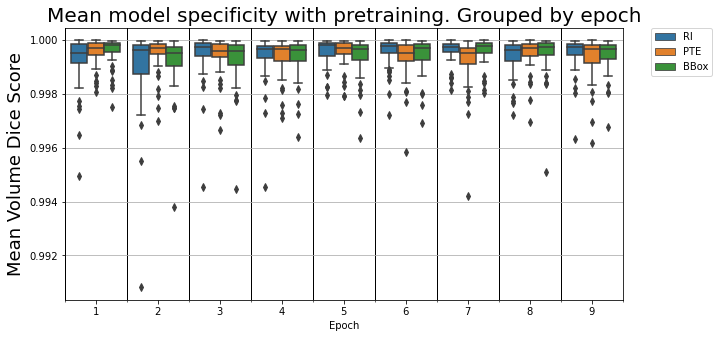


Epoch 4
+-------------+--------------------+--------------------+--------------------+
|    Metric   |         RI         |        PTE         |        BBox        |
+-------------+--------------------+--------------------+--------------------+
|     dice    | 0.8425696879040313 | 0.839625677659802  | 0.8530698408182301 |
|     hd95    | 11.168343079717532 | 11.031418596234234 | 10.709930646628663 |
|  precision  | 0.9452310808773533 | 0.9380919411311799 | 0.9270919083231286 |
|    recall   | 0.7796329232527546 | 0.7820488399538619 | 0.8076157519149585 |
| specificity | 0.9995989295111477 | 0.9995758184847493 | 0.9994289310866477 |
+-------------+--------------------+--------------------+--------------------+

####################################################################################################
####################################################################################################
#############################################################################

In [28]:
# Additional metrics evaluated, formatted in a table
import numpy as np
import os 
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv  

from prettytable import PrettyTable

metric_out = []
hd95 = []

from os import listdir
from os.path import isfile, join

epoch_num = 9
output_epoch = 4
folder_list = [[],[]]
in_type = ["RI","PTE","BBox"]
index = range(epoch_num)

# recall = sensitivity

#BBOX_training_sample_1_RI
#RANO_cosine_cont_3_PTE

in_path = [os.getcwd() + "/Test_outputs/Random_init_model_100data/",
           os.getcwd() + "/Test_outputs/PTE_cosine_3_100data/",
           os.getcwd() + "/Test_outputs/bbox_test/"]

col_name = []
for xx in range(epoch_num):
    col_name.append(str(xx + 1))

metrics_table = PrettyTable(['Metric','RI', 'PTE','BBox'])
for metric in ["dice","hd95","precision","recall", "specificity"]:

    x_array = np.array([])
    y_array = np.array([])
    z_array = np.array([])
    
    metric_output = []

    folder_len = len(listdir(in_path[0]))

    out_x = np.empty([epoch_num, 57])
    out_y = np.empty([epoch_num, 57])
    out_z = np.empty([epoch_num, 57])

    train_data_input = pd.DataFrame(data=None, columns=in_type)

    for val in range(len(in_type)):
        dice_output = []

        df1 = pd.DataFrame({"RI" : [], "PTE" : []})

        for epoch in range(epoch_num):
            metric_out = []

            x_array = np.array([])
            y_array = np.array([])
            z_array = np.array([])

            folder_list = [f for f in listdir(in_path[val] + "/Epoch_"
                                              +str(epoch)+"/Metrics/") if isfile(join(in_path[val] 
                                                                                      + "Epoch_"+str(epoch)+"/Metrics/",
                                                                                      f))]

            for folder in range(len(folder_list)):

                with open(in_path[val] + "/Epoch_"+str(epoch)+"/Metrics/" + folder_list[folder]) as f:
                    reader = csv.DictReader(f)
                    for row in reader:
                        if metric == "specificity":
                            tp, tn, fp, fn = row['TP'], row['TN'], row['FP'], row['FN']

                            specificity = float(tn) / (float(tn) + float(fp))
                            metric_out.append(specificity)
                        else:

                            metric_out.append(row[metric])

            if in_type[val] == "RI":
                x_array = np.append(x_array, metric_out)
                out_x[epoch] = x_array

            if in_type[val] == "PTE":
                y_array = np.append(y_array, metric_out)
                out_y[epoch] = y_array
                
            if in_type[val] == "BBox":
                z_array = np.append(z_array, metric_out)
                out_z[epoch] = z_array

            x_array = x_array.astype(np.float)
            y_array = y_array.astype(np.float)
            z_array = z_array.astype(np.float)

    for var in range(len(out_x)):
        df1 = pd.DataFrame(data = {"Epoch":np.full(len(out_x[var]), 
                                                   col_name[index[var]]),
                                   "RI":out_x[var],
                                   "PTE":out_y[var],
                                   "BBox":out_z[var]})

        train_data_input = train_data_input.append(df1,ignore_index=True)

        t = PrettyTable(['Epoch',"RI " + metric, "PTE " + metric, "BBox " + metric])
        for a in range(epoch_num):
            t.add_row([a, np.mean(out_x[a]), np.mean(out_y[a]), np.mean(out_z[a])])

    for f_epoch in [output_epoch]:
        metrics_table.add_row([metric, np.mean(out_x[output_epoch]), np.mean(out_y[output_epoch]), np.mean(out_z[output_epoch])])
        print(t)
        metric_out = []
    x_array = np.array([])
    y_array = np.array([])
    z_array = np.array([])

    data = train_data_input.melt('Epoch', var_name='Model Pre-training level', value_name='Mean Dice')
    fig = plt.figure(figsize=(10,5))
    plt.grid()
    ax=sns.boxplot(y='Mean Dice', x='Epoch', hue='Model Pre-training level', data=data)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title("Mean model " + metric + " with pretraining. Grouped by epoch",fontsize=20)
    if metric == "dice":
        plt.ylim(-0.05,1.05)
    if metric == "hd95":
        plt.ylim(-5,125)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1)
    plt.ylabel("Mean Volume Dice Score",fontsize=18)
    plt.show()
print("")
print("Epoch " + str(output_epoch))
print(metrics_table)
print("")
print("####################################################################################################")
print("####################################################################################################")
print("####################################################################################################")
